In [1]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from PIL import Image
from torchsummary import summary

In [10]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
#  validation sample
valid_sample = 0.2

transform = [transforms.Pad(2), transforms.ToTensor()]

# choose the training and test datasets
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.Compose(transform))
# test_data = datasets.MNIST(root='data',
#                            train=False,
#                            download=True,
#                            transform=transforms.Compose(transform))

# Creating validation sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_sample * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for batches
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=trainSampler,
                          num_workers=num_workers)
validation_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               sampler=validationSampler,
                               num_workers=num_workers)

transform1 = transforms.Compose([transforms.Pad(2),transforms.ToTensor(),
                                transforms.Normalize((0,), (1,))])

# train_dataset = datasets.MNIST('./MNIST/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./MNIST/', train=False, transform=transform1, download=True)


# train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

# train_dataset_array = next(iter(train_loader))[0].numpy()
test_dataset_array = next(iter(test_loader))[0].numpy()

In [11]:
print(test_dataset_array.shape)

(10000, 1, 32, 32)


In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 32 x 32 x 1
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=0, stride=1)
        # 28 x 28 x 6
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        # 14 x 14 x 6
        self.conv2 = nn.Conv2d(6, 16, (5, 5), padding=0, stride=1)
        # 10 x 10 x 16
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        # 5 x 5 x 16
        self.conv3 = nn.Conv2d(16, 120, (5, 5), padding=0, stride=1)
        # 1 x 1 x 120
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # Choose either view or flatten (as you like)
        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x
      
model = LeNet()
model = model.cuda()
print(model)
summary(model, input_size=(1, 32, 32))

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          1

In [13]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
n_epochs = 30

# classes of MNIST
classes = list(range(10))


In [14]:

# # Choosing the device for training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("Training Device: {}".format(device))

# model.to(device)

# valid_loss_min = np.Inf

# for epoch in range(n_epochs):

#     # monitor training loss
#     train_loss = 0.0
#     valid_loss = 0.0

#     ###################
#     # train the model #
#     ###################
#     model.train()  # prep model for training
#     for data, target in train_loader:
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = model(data.to(device))
#         # calculate the loss
#         loss = criterion(output, target.to(device))
#         # backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
#         # perform a single optimization step (parameter update)
#         optimizer.step()
#         # update running training loss
#         train_loss += loss.item() * data.size(0)

#     model.eval()
#     for data, target in validation_loader:
#         output = model(data.to(device))
#         loss = criterion(output, target.to(device))
#         valid_loss += loss.item() * data.size(0)

#     # print training statistics
#     # calculate average loss over an epoch
#     train_loss = train_loss / len(train_loader.sampler)
#     valid_loss = valid_loss / len(validation_loader.sampler)

#     print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.
#           format(epoch + 1, train_loss, valid_loss))
#     if valid_loss <= valid_loss_min:
#         print(
#             'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
#             .format(valid_loss_min, valid_loss))
#         torch.save(model.state_dict(), 'model.pt')
#         valid_loss_min = valid_loss


Training Device: cuda:0
Epoch: 1 	Training Loss: 2.302081 	Validation Loss: 2.301655
Validation loss decreased (inf --> 2.301655).  Saving model ...
Epoch: 2 	Training Loss: 2.300553 	Validation Loss: 2.299249
Validation loss decreased (2.301655 --> 2.299249).  Saving model ...
Epoch: 3 	Training Loss: 2.286930 	Validation Loss: 2.192971
Validation loss decreased (2.299249 --> 2.192971).  Saving model ...
Epoch: 4 	Training Loss: 1.877304 	Validation Loss: 1.752631
Validation loss decreased (2.192971 --> 1.752631).  Saving model ...
Epoch: 5 	Training Loss: 1.728458 	Validation Loss: 1.717350
Validation loss decreased (1.752631 --> 1.717350).  Saving model ...
Epoch: 6 	Training Loss: 1.709722 	Validation Loss: 1.671227
Validation loss decreased (1.717350 --> 1.671227).  Saving model ...
Epoch: 7 	Training Loss: 1.640996 	Validation Loss: 1.620904
Validation loss decreased (1.671227 --> 1.620904).  Saving model ...
Epoch: 8 	Training Loss: 1.620415 	Validation Loss: 1.625274
Epoch: 9 	

In [15]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model = LeNet()
model.load_state_dict(torch.load("model.pt"))
model.eval()  # prep model for *evaluation*

# Choosing the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Testing Device: {}".format(device))

model.to(device)

# Disabling the gradient calculations for faster inference
with torch.no_grad():

  for data, target in test_loader:
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data.to(device))
      # calculate the loss
      loss = criterion(output, target.to(device))
      # update test loss
      test_loss += loss.item() * data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %
              (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))


Testing Device: cuda:0
Test Loss: 1.479761

Test Accuracy of     0: 100% ( 3/ 3)
Test Accuracy of     1: 100% ( 3/ 3)
Test Accuracy of     2: 100% ( 1/ 1)
Test Accuracy of     3: 100% ( 1/ 1)
Test Accuracy of     4: 100% ( 3/ 3)
Test Accuracy of     5: 100% ( 2/ 2)
Test Accuracy of     6: 100% ( 1/ 1)
Test Accuracy of     7: 100% ( 2/ 2)
Test Accuracy of     8: N/A (no training examples)
Test Accuracy of     9: 100% ( 4/ 4)

Test Accuracy (Overall): 100% (20/20)


In [16]:

def quantize_arr(arr):
    ''' Quantization based on linear rescaling over min/max range.'''
    min_val, max_val = np.min(arr), np.max(arr)

    if max_val - min_val > 0:
        quantized = np.round(255 * (arr - min_val) / (max_val - min_val))
    else:
        quantized = np.zeros(arr.shape)

    quantized = quantized.astype(np.uint8)
    min_val = min_val.astype(np.float32)
    max_val = max_val.astype(np.float32)

    return quantized, min_val, max_val

# example = np.random.randn(5, 5)
# print(example)
# quant, min_val, max_val = quantize_arr(example)
# print("\n{}, Min_Val: {}, Max_Val: {}".format(quant, min_val, max_val))  
    


torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 16, 5, 5])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0.

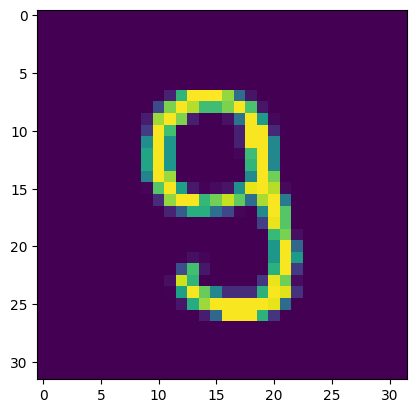

In [21]:
param = list(model.parameters())
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
%matplotlib inline

# Moving the model back to the CPU
model.to("cpu")

# parameters of the trained network
param = list(model.parameters())
for paramater in model.parameters():
  print(paramater.shape)
  
for k in range (0,480):
   
    # Input image for analysis
    # input_img_dataset = test_loader.dataset.data[k].squeeze(0)
    input_img = next(iter(test_loader))[0][k].squeeze(0)
    plt.imshow(input_img)
    # plt.imshow(input_img_dataset)
    
    # Modifying the input image for analysis
    input_img = input_img.unsqueeze(0).unsqueeze(0)
    # savemat('input_img.mat', {'input_img':input_img})
    # files.download('input_img.mat')
    temp_2 = input_img.detach().numpy()
    print(temp_2)
    print(temp_2.squeeze(0).squeeze(0))
    input_image = temp_2.squeeze(0).squeeze(0)
    # print(input_image.shape)
    # plt.imshow(input_image)
    # savemat(f'input_image_{k}.mat',{'input_image_{k}':input_image})
    # plt.figure(figsize=(10, 10))
    # row = 2
    # columns = 3
    # for i in range(6):
    #     output_fm = model.conv1.forward(input_img)[0][i].detach().numpy()
    # savemat(f'output_fm_conv{k}.mat', {f'output_fm_conv{k}':output_fm})

    # plt.figure(figsize=(10, 10))
    # row = 2
    # columns = 3
    # for i in range(6):
    #     output, min_val, max_val = quantize_arr(
    #         model.conv1.forward(input_img)[0][i].detach().numpy())
    #     plt.subplot(6 / columns + 1, columns, i + 1)
    #     plt.imshow(output)
    # savemat(f'quantized_output_conv{k}.mat', {f'quantized_output_conv{k}':output})
    weights = []
    bias = []
    for i in range(6):
        # print("{}, Bias: {}\n".format(param[0][i].data, param[1][i]))
        # print("Min: {}, Max: {}\n".format(np.min(param[0][i].data.numpy()), np.max(param[0][i].data.numpy())))
        w = param[0][i].data.detach().numpy()
        # print(w.shape)
        w = w.squeeze(0)
        # print(w.shape)
        # print(w)
        name = 'W'+str(i)+'_L1'
        # print(name)
        # savemat(name+'.mat', {name:w})
    param = list(model.parameters())
    # plt.figure(figsize=(5, 5))
    # row = 2
    # columns = 3
    for i in range(6):
        output, min_val, max_val = quantize_arr(
            model.pool1.forward(
                model.conv1.forward(input_img))[0][i].detach().numpy())
        # plt.subplot(6 / columns + 1, columns, i + 1)
        # plt.imshow(output)
    savemat(f'output_fm_pool_{k}.mat', {f'output_fm_pool_{k}':output})
    # # files.download('output_fm_pool1.mat')
    # plt.figure(figsize=(5, 5))
    # row = 4
    # columns = 4
    # for i in range(16):
    #     output, min_val, max_val = quantize_arr(
    #         model.conv2.forward(
    #             model.pool1.forward(
    #                 model.conv1.forward(input_img)))[0][i].detach().numpy())
    #     # plt.subplot(16 / columns + 1, columns, i + 1)
    #     # plt.imshow(output)
    # savemat('output_fm_conv2.mat', {'output_fm_conv2':output})
    # weights = []
    # bias = []
    # for i in range(16):
    # print("{}, Bias: {}\n".format(param[2][i].data, param[3][i]))
    # print("Min: {}, Max: {}\n".format(np.min(param[2][i].data.numpy()), np.max(param[2][i].data.numpy())))
    # w = param[2][i].data.detach().numpy()
    # print(w.shape)
    # # w = w.squeeze(0)
    # # print(w.shape)
    # print(w)
    # name = 'W'+str(i)+'_L2'
    # print(name)
    # savemat(name+'.mat', {name:w})
    # plt.figure(figsize=(5, 5))
    # row = 4
    # columns = 4
    # for i in range(16):
    #     output, min_val, max_val = quantize_arr(
    #         model.pool2.forward(
    #             model.conv2.forward(
    #                 model.pool1.forward(
    #                     model.conv1.forward(input_img))))[0][i].detach().numpy())
    #     # plt.subplot(16 / columns + 1, columns, i + 1)
    #     # plt.imshow(output)
    # savemat('output_fm_pool2.mat', {'output_fm_pool2':output})